<div style="text-align: left">
<img src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="800px">
</div>

# [RAMP](https://www.ramp.studio/problems/storm_forecast) on Tropical Storm Intensity Forecast

_Sophie Giffard-Roisin (AppStat), Mo Yang (AppStat), Balazs Kegl (AppStat-CDS), Claire Monteleoni (AppStat), Alexandre Boucaud (AppStat-CDS)_

1. [Introduction](#Introduction)
2. [Installation of libraries](#Installation Libraries) : To do before coming!
2. [The data](#The data)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction

The goal of the hackathon is to predict the intensity of tropical and extra-tropical storms (24h forecast) using information from past storms since 1979. The intensity can be measured as the maximum sustained wind over a period of one minute at 10 meters height. This speed, calculated every 6 hours, is usually explained in knots (1kn=0.514 m/s) and is used to define the hurricane category from the [Saffir-Simpson scale](https://en.wikipedia.org/wiki/Saffir–Simpson_scale). Estimating the intensity evolution of a storm is of course crucial for the population.

<img src="https://github.com/sophiegif/ramp_kit_storm_forecast/blob/master/figures_pynb/all_storms_since1979_IBTrRACKS_newcats.png?raw=true" width="70%">
<div style="text-align: center">Database: tropical/extra-tropical storm tracks since 1979. Dots = initial position, colors = maximal storm strength according to the Saffir-Simpson scale.</div>

Today, the forecasts (track and intensity) are provided by a numerous number of guidance models (1). Dynamical models solve the physical equations governing motions in the atmosphere. Statistical models, in contrast, are based on historical relationships between storm behavior and various other parameters. However, the lack of improvement in intensity forecasting is attributed to the complexity of tropical systems and an incomplete understanding of factors that affect their development. Moreover, since the 1990s there have been more storms -particularly at low latitudes- leading to both more representative and more consistent error statistics. Machine learning (and deep learning) methods have been only scarsely tested, and there is hope in that it can improve storm forecasts.

Forecast intensity error is defined as the absolute value of the difference between the forecast and best track intensity at the forecast verifying time. 





### The prediction task

<img src="https://github.com/sophiegif/ramp_kit_storm_forecast/blob/master/figures_pynb/storm_shema3.png?raw=true" width="35%">
<div style="text-align: center">Goal of the challenge: estimating the 24h-forecast intensity of all tropical storms.</div>

This challenge proposes to design the best algorithm to predict for a large number of storms the 24h-forecast intensity every 6 hours. The (real) database is composed of more than 3000 extra-tropical and tropical storm tracks, and it also provides the intensity and some local physical information at each timestep (2). Moreover, we also provide the 700-hPa altitudes of the neighborhood of the storm (from ERA-interm reanalysis database), that can be viewed as an image centered on the current storm location (3).

The goal is to provide for each time step of each storm (total number of instants =90 000), the predicted 24h-forecast intensity, so 4 time steps in the future. 



### References

1. National Hurricane Center Forecast Verification website, https://www.nhc.noaa.gov/verification/, updated 04 April 2017.

2. Knapp, K. R., M. C. Kruk, D. H. Levinson, H. J. Diamond, and C. J. Neumann, 2010: The International Best Track Archive for Climate Stewardship (IBTrACS): Unifying tropical cyclone best track data. Bulletin of the American Meteorological Society, 91, 363-376 https://www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data

3. Dee, D. P. et al.(2011), The ERA-Interim reanalysis: configuration and performance of the data assimilation system. Q.J.R. Meteorol. Soc., 137: 553–597. https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.828


## Installation of libraries

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://docs.anaconda.com/docs_oss/conda/install/quick#miniconda-quick-install-requirements). (uncomment the lines before running them)

In [ ]:
# !conda install -y -c conda conda-env     # First install conda-env to ease the creation of virtual envs in conda
# !conda env create                        # Uses the local environment.yml file to create the 'storm_forecast' env

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [ ]:
# !pip install -r requirements.txt

#### Installation of ramp-workflow

For being able to test submissions, you also need to have the `ramp-workflow` package locally. You can install the latest version with pip from github:

In [ ]:
# !pip install git+https://github.com/paris-saclay-cds/ramp-workflow

#### Download data (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.
The starting kit data is 260 MB.

In [ ]:
# !python download_data.py

## The data

The 3000 storms data has been separated in a train set, a test set and a local starting kit (train+test sets). The data from `download_data.py` (local starting kit) includes only 1/4 storms of the total database; and the train set on which your code will run on the platform has another half. They are disjoined. 

Let's have a look at the local train data.

In [1]:
from problem import get_train_data
import numpy as np

data_train, y_train = get_train_data()

In [2]:
data_train.head()

,stormid,instant_t,latitude,longitude,windspeed,hemisphere,Jday_predictor,initial_max_wind,max_wind_change_12h,basin,...,z_24_15,z_24_16,z_24_17,z_24_18,z_24_19,z_24_20,z_24_21,z_24_22,z_24_23,z_24_24
0,1979198N11256,0,10.5,-103.7,25.0,1,0.006923,25.0,0.0,3,...,114816.654113,114819.087566,114823.954472,114826.387926,114819.087566,114789.886130,114758.251241,114731.483258,114697.414916,114665.780026
1,1979198N11256,1,10.9,-105.3,30.0,1,0.006923,25.0,5.0,3,...,114607.377154,114600.076795,114600.076795,114604.943701,114607.377154,114600.076795,114597.643342,114595.209889,114580.609171,114563.575000
2,1979198N11256,2,11.2,-107.0,35.0,1,0.006923,25.0,10.0,3,...,114794.753036,114767.985053,114748.517429,114738.783617,114741.217070,114748.517429,114733.916711,114716.882540,114694.981463,114668.213479
3,1979198N11256,3,11.0,-108.9,35.0,1,0.006923,25.0,5.0,3,...,114765.551600,114726.616352,114687.681104,114653.612761,114624.411325,114602.510248,114597.643342,114602.510248,114590.342983,114587.909530
4,1979198N11256,4,11.2,-110.2,40.0,1,0.006923,25.0,5.0,3,...,114804.486848,114782.585771,114731.483258,114670.646932,114600.076795,114527.073204,114461.369973,114429.735084,114420.001272,114424.868178


In [3]:
print(y_train)

[40. 50. 65. ... 45. 30. 20.]


You can see that the data is a list of time instants: for the first storm - defined by its stormid-, we have for ex. 26 time steps (one every 6h). It will result in 26 lines beginning with its stormid and the corresponding time step, with all the associated features on the same row. Then the time steps from the second storm will be below, and so on. 

In [6]:
print('Number of storms in the local training set: {}'.format( len(set(data_train['stormid'])) ) )

Number of storms in the local training set: 585


In [7]:
print('Total number of time steps in the local training set: {}'.format(y_train.size))

Total number of time steps in the local training set: 15566


### 0D features from track data

A set of simple features have been extracted for each storm at each time point: 

- latitude, longitude: in degrees
- windspeed: current (max) windspeed (knots) 
- hemisphere:  South=0, North=1
- Jday predictor:  Gaussian function of (Julian day of storm init - peak day of the hurricane season), see (1)
- initial_max_wind: initial (max) windspeed of the storm 
- max_wind_change_12h: last 12h (max) windspeed change
- basin= based on present location: 
                                    0 = NA - North Atlantic
                                    1 = SA - South Atlantic
                                    2 = WP - West Pacific
                                    3 = EP - East Pacific
                                    4 = SP - South Pacific
                                    5 = NI - North Indian
                                    6 = SI - South Indian
                                    7 = AS - Arabian Sea
                                    8 = BB - Bay of Bengal
                                    9 = EA - Eastern Australia
                                    10 = WA - Western Australia
                                    11 = CP - Central Pacific
                                    12 = CS - Carribbean Sea
                                    13 = GM - Gulf of Mexico
                                    14 = MM - Missing
- nature= nature of the storm  
                               0 = TS - Tropical
                               1 = SS - Subtropical
                               2 = ET - Extratropical
                               3 = DS - Disturbance
                               4 = MX - Mix of conflicting reports
                               5 = NR - Not Reported
                               6 = MM - Missing
                               7 =  - Missing
- dist2land= current distance to the land 


(1) DeMaria, Mark, et al. "Further improvements to the statistical hurricane intensity prediction scheme (SHIPS)." Weather and Forecasting 20.4 (2005): 531-543. https://journals.ametsoc.org/doi/full/10.1175/WAF862.1

### The reanalysis data

At each time step, a grid of the 700hPa-level pressure altitude (centered on the current storm location) has been extracted. 

In [8]:
data_train_z = data_train[[col for col in data_train.columns if col.startswith('z_')]]
data_train_z.head()

,z_0_0,z_0_1,z_0_2,z_0_3,z_0_4,z_0_5,z_0_6,z_0_7,z_0_8,z_0_9,...,z_24_15,z_24_16,z_24_17,z_24_18,z_24_19,z_24_20,z_24_21,z_24_22,z_24_23,z_24_24
0,114383.499476,114383.499476,114385.932929,114385.932929,114385.932929,114385.932929,114388.366382,114388.366382,114388.366382,114390.799835,...,114816.654113,114819.087566,114823.954472,114826.387926,114819.087566,114789.886130,114758.251241,114731.483258,114697.414916,114665.780026
1,114062.283678,114062.283678,114064.717131,114067.150584,114067.150584,114064.717131,114062.283678,114062.283678,114064.717131,114067.150584,...,114607.377154,114600.076795,114600.076795,114604.943701,114607.377154,114600.076795,114597.643342,114595.209889,114580.609171,114563.575000
2,114278.860997,114273.994091,114269.127185,114266.693732,114269.127185,114271.560638,114271.560638,114271.560638,114271.560638,114271.560638,...,114794.753036,114767.985053,114748.517429,114738.783617,114741.217070,114748.517429,114733.916711,114716.882540,114694.981463,114668.213479
3,114127.986910,114127.986910,114125.553457,114123.120004,114120.686551,114120.686551,114120.686551,114118.253098,114120.686551,114123.120004,...,114765.551600,114726.616352,114687.681104,114653.612761,114624.411325,114602.510248,114597.643342,114602.510248,114590.342983,114587.909530
4,114366.465305,114371.332211,114378.632570,114385.932929,114390.799835,114398.100195,114400.533648,114402.967101,114405.400554,114407.834007,...,114804.486848,114782.585771,114731.483258,114670.646932,114600.076795,114527.073204,114461.369973,114429.735084,114420.001272,114424.868178


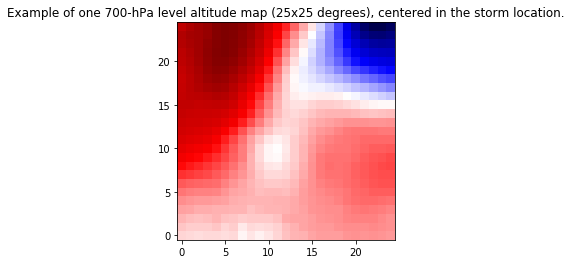

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

grid_l=25
z_image=np.zeros([grid_l,grid_l])
for i in range(grid_l):
     for j in range(grid_l):
        z_image[i,j]=data_train_z['z_'+str(i)+'_'+str(j)][50]

plt.title('Example of one 700-hPa level altitude map (25x25 degrees), centered in the storm location.')
plt.imshow(np.array(z_image),interpolation='nearest', origin='lower', cmap='seismic')

## The pipeline

<img src="https://github.com/sophiegif/ramp_kit_storm_forecast/blob/master/figures_pynb/pipeline.png?raw=true" width="70%">

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in a specific file:   

* a class `FeatureExtractor` in a `feature_extractor.py` file.
* a class `Regressor` in a `regressor.py` file.

You can look at the simple examples provided in /submissions:
- starting_kit : using only the track data
- starting_kit_pressure_map : using both track data and image data

### Using data from previous time steps
Of course, you can use the data from previous time steps, e.g., for the prediction of the intensity of storm S at t=3 you can use data from S at t=\[0:2\]. However, it is completely forbidden (and we check it!) to use future data like S at t=4,.. 

- illegal_lookahead : this simple submission illustrates the error you will have if you are illegally looking ahead time of the same storm.

## Evaluation
The framework is evaluated with a cross-validation approach. The metric used is the RMSE (root mean square error) in knots across all storm time instants. We also made visible three other metrics: `mae` is the mean absolute error, in knots. `mae_hurr` is the MAE using only time instants corresponding to hurricanes (windspeed>64 knots), while `rel_mae_hurr` is the relative RMSE on hurricanes. These metrics are interesting because the current forecasting practice is to exclude all other stages of development (e.g., extratropical, tropical wave...), see [this page](https://www.nhc.noaa.gov/verification/verify5.shtml?).

## Testing the submission
We can test locally our pipeline using `ramp_test_submission` command line from your storm_forecast/ folder. (`-h` will give you more infos).
Then, you can save your codes in /submission/<submission_name> and run `ramp_test_submission -_submission --<submission_name>`

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Some attention points when building the model

<div class="alert alert-danger">

 <ul>
  <li>If you want to use the features from previous time steps in your learning (for example using LSTMs), you will have to use the 'stormid' and the 'instant_t' columns. Moreover, you will have to handle separetly the first time steps, which are not provided with past data.</li>
  <li>The intensity value to predict is the max windspeed. However, this value was measured empirically with a precision of ~5knots. </li>
</ul> 

</div>

## Submitting to the online challenge: [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](http://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then sign up to the event [storm_forecast](http://www.ramp.studio/events/storm_forecast). Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/storm_forecast/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py). Save it, rename it, then submit it. The submission is trained and tested on our backend in the similar way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/storm_forecast/my_submissions). Once it is trained your submission shows up on the [public leaderboard](http://www.ramp.studio/events/autism/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/storm_forecast/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/storm_forecast/leaderboard)) is the RMSE.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Storm forecast ramp).